# Melomind Test Data Analysis

## Imports and Presets

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

### Define Project-Root Directory

In [3]:
PROJECT_ROOT = 'bio-feedback'

### Navigate to Project-Root Directory

In [4]:
currend_wd = os.getcwd()
project_root_abs = os.path.join(currend_wd[:currend_wd.find(PROJECT_ROOT)], PROJECT_ROOT)
os.chdir(project_root_abs)

### Import Project-Specific Libraries

In [5]:
from biofb.io import SessionDatabase as SessionDB

## Load captured data

In [6]:
test_db = SessionDB.load(filename='data/session/db-2020-12-18-melomind.yml')

### Available measurements:

In [7]:
for i, sample in enumerate(test_db.samples):
    print(f'Sample {i}: {sample}')

Sample 0: <Sample: Subject 882947 at 2020-12-18 17:19:00>
Sample 1: <Sample: Subject 925022 at 2020-12-18 17:38:00>
Sample 2: <Sample: Subject 882947 at 2021-01-04 21:34:00>


### Extract data, time and meta_data of measurements

In [8]:
data = test_db.data
time_data = test_db.time
meta_data = test_db.meta

### Interactive visualization of measurements

In [9]:
tmax = int(max([len(d[0][:, 0]) for d in data])/250)

@interact
def view_eeg(
    t = IntSlider(value=1, min=1, max=tmax, step=1),
    delta_t = IntSlider(value=tmax, min=1, max=tmax, step=1),
    ylim = '0.0004',
    sample=[i for i in range(len(data))],
):

    s = test_db.samples[int(sample)]
    s_time, s_data = time_data[int(sample)][0], data[int(sample)][0]
        
    xlim = [t-1, min(t  + delta_t, len(s_data)/250.)]
    ylim = np.asarray([-float(ylim), float(ylim)])
    
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))

    ax1.set_title(s)

    ax1.plot(s_time[:, 0], s_data[:, 0] + 1e-4, label=s.labels[0] + ' ( + $10^{ '+ '-4})$')
    ax1.plot(s_time[:, 1], s_data[:, 1] - 1e-4, label=s.labels[1] + ' ( - $10^{ '+ '-4})$')
    ax1.set_xlabel('Time [sec.]')
    ax1.set_ylabel('Electrode Signals [mV]')
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)

    ax2.plot(s_time[:, 0], s_data[:, 0] - s_data[:, 1], label='EEG_1 - EEG_2')
    ax2.set_xlabel('Time [sec.]')
    ax2.set_ylabel('Electrode Signals Spatial Filter [mV]')
    ax2.set_ylim(ylim/2.)
    ax2.set_xlim(xlim)

    ax3.plot(s_time[:, 2], s_data[:, 2], label=s.labels[2])
    ax3.plot(s_time[:, 3], s_data[:, 3], label=s.labels[3])
    ax3.set_xlabel('Time [sec.]')
    ax3.set_ylabel('Signal Quality')
    ax3.set_xlim(xlim)
    
    ax1.legend()
    ax2.legend()
    ax3.legend()


interactive(children=(IntSlider(value=1, description='t', max=710, min=1), IntSlider(value=710, description='d…

### Spectrogram of *good data* (constrained by indices) of measurement `0` (BH)

In [10]:
def plot_spectrogram(sample, data_slice=slice(None,None,None)):
    test_data = test_db.samples[sample].data[0]  # access melomind data
    print(test_db.samples[sample])

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5), sharey=True)

    Pxx, freqs, bins, im = ax1.specgram(test_data[data_slice, 0], NFFT=250, Fs=250, noverlap=125, scale='dB', cmap='magma')
    ax1.set_title('Spectrogram `Signal 1`')

    ax2.specgram(test_data[data_slice, 1], NFFT=250, Fs=250, noverlap=125, scale='dB', cmap='magma')
    ax2.set_title('Spectrogram `Signal 2`')

    ax3.specgram(test_data[data_slice, 0] - test_data[data_slice, 1], 
                 NFFT=250, Fs=250, noverlap=125, scale='dB', cmap='magma')
    ax3.set_title('Spektrogram `Spatial Filter (Signal 1 minus Signal 2)`')

    ax1.set_xlabel('Time')
    ax2.set_xlabel('Time')
    ax3.set_xlabel('Time')
    ax1.set_ylabel('Frequency')

    plt.show()

<Sample: Subject 882947 at 2020-12-18 17:19:00>


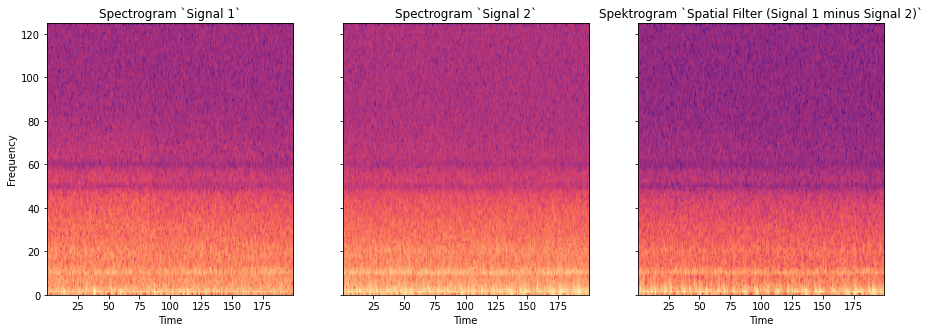

In [11]:
plot_spectrogram(sample=0, data_slice=slice(2000 + 200*250, 2000 + 400*250))

### Spectrogram of *good data* (constrained by indices) of measurement `1` (RB)

<Sample: Subject 925022 at 2020-12-18 17:38:00>


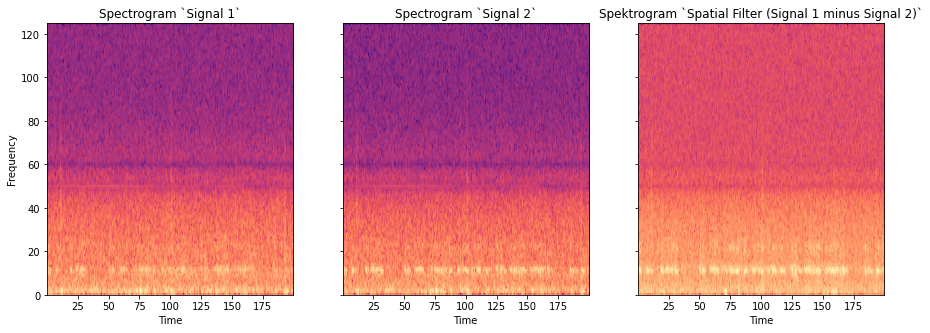

In [12]:
plot_spectrogram(sample=1, data_slice=slice(2000 + 200*250, 2000 + 400*250))

### Spectrogram of *test data* measurement `2` (BH)

<Sample: Subject 882947 at 2021-01-04 21:34:00>


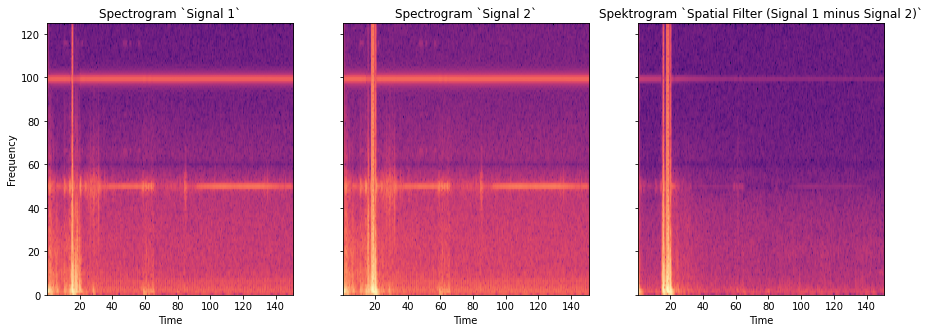

In [13]:
plot_spectrogram(sample=2)

### Direct evaluation of spectrograms using `scipy.signal.stft` (short time Fourier transform)
- *I do have a plot issue with the aspect ratio of below images*

In [14]:
from scipy import signal
from matplotlib.colors import LogNorm

In [15]:
def stft(sample):
    sample = test_db.samples[sample]    
    data = sample.data[0]

    noverlap = sample.setup.devices[0].channels[0].sampling_rate//2
    nfft = sample.setup.devices[0].channels[0].sampling_rate
    nperseg = sample.setup.devices[0].channels[0].sampling_rate
    
    yy, xx, zz_signal_0 = signal.stft(data[:, 0], noverlap=noverlap, nfft=nfft, nperseg=nperseg)
    yy, xx, zz_signal_1 = signal.stft(data[:, 1], noverlap=noverlap, nfft=nfft, nperseg=nperseg)
    yy, xx, zz_filter = signal.stft(data[:, 0] - data[:, 1], noverlap=125, nfft=nfft, nperseg=nperseg)
    
    return xx, yy, [zz_signal_0, zz_signal_1, zz_filter]

In [16]:
def evaluate_stft(sample, plot=True):
    xx, yy, [zz_signal_0, zz_signal_1, zz_filter] = stft(sample=sample)

    norm_signal_0 = LogNorm(vmin=np.amin(np.absolute(zz_signal_0)), vmax=np.amax(np.absolute(zz_signal_0)))
    norm_signal_1 = LogNorm(vmin=np.amin(np.absolute(zz_signal_1)), vmax=np.amax(np.absolute(zz_signal_1)))
    norm_filter = LogNorm(vmin=np.amin(np.absolute(zz_filter)), vmax=np.amax(np.absolute(zz_filter)))

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15), sharey=True, sharex=True)

    ax1.set_title('Spectrogram `Signal 1`')
    ax1.imshow(np.absolute(zz_signal_0), cmap='magma', norm=norm_signal_0)
    ax1.set_aspect(zz_signal_0.shape[1]/zz_signal_0.shape[0])
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Frequency')

    ax2.set_title('Spectrogram `Signal 2`')
    ax2.imshow(np.absolute(zz_signal_1), cmap='magma', norm=norm_signal_1)
    ax2.set_aspect(zz_signal_1.shape[1]/zz_signal_1.shape[0])
    ax2.set_xlabel('Time')

    ax3.set_title('Spectrogram `Spacial Filter (Signal 1 minus Signal 2)`')
    ax3.imshow(np.absolute(zz_filter), cmap='magma', norm=norm_filter)
    ax3.set_aspect(zz_filter.shape[1]/zz_filter.shape[0])
    ax3.set_xlabel('Time')

    plt.show()
    
    return xx, yy, [zz_signal_0, zz_signal_1, zz_filter]

In [17]:
@interact
def view_eeg(sample=[0,1,2]):
    print(test_db.samples[sample])
    __ = evaluate_stft(sample=sample, plot=True)

interactive(children=(Dropdown(description='sample', options=(0, 1, 2), value=0), Output()), _dom_classes=('wi…

### Power Spectrum over the entire signal

In [18]:
@interact
def view_eeg(sample=[0,1,2], show_filter=False, show_diff=False, fmax='126'):
    sample = test_db.samples[sample]    
    sample_data = sample.data[0]  # access device data
    
    fmax = float(fmax)    

    plt.figure(figsize=(15,5))
    f, Pxx_den_0 = signal.welch(sample_data[2000:-1000, 0], 1., nperseg=250)
    f, Pxx_den_1 = signal.welch(sample_data[2000:-1000, 1], 1., nperseg=250)
    f, Pxx_den_01 = signal.welch(sample_data[2000:-1000, 0] - sample_data[2000:-1000, 1], 1., nperseg=250)
    plt.semilogy(Pxx_den_0, label='Signal 1')
    plt.semilogy(Pxx_den_1, label='Signal 2')
    if show_filter: plt.semilogy(Pxx_den_01, label='Signal 1-2', color='tab:green')
    if show_diff: plt.semilogy(np.absolute(Pxx_den_0-Pxx_den_1), label='Pow(Signal 1) - Pow(Signal 2)', color='tab:red')
    plt.xlabel('Frequencies')
    plt.ylabel('Power')
    plt.xlim([0,fmax])
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='sample', options=(0, 1, 2), value=0), Checkbox(value=False, descri…

- We see, that there is a maximum intensity at low frequencies (probably corresponding to the $\theta$ wave).
- Further, we see a $10Hz$ $\alpha$ peak in the intensity plot.
- There appear to be two filters active in the device at $50Hz$ and $60Hz$ (corresponding to the network frequencies of European and American power lines)


## Clustering of Frequency Data

In [19]:
sample = 1
s = test_db.samples[sample]
s_data = s.data[0]
s_time = s.time[0]
t0 = 0
t1 = -1
ylim_abs = 0.0004

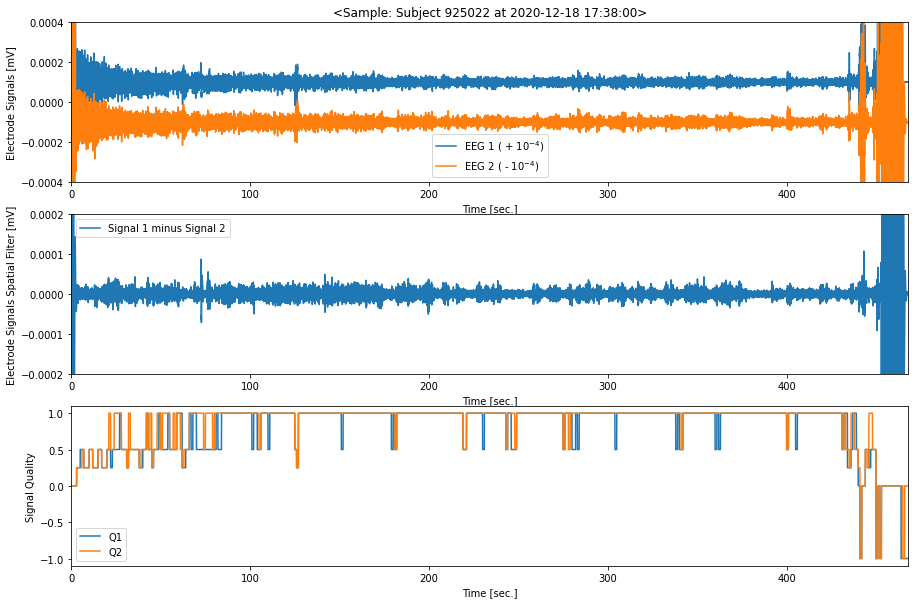

In [20]:
t0_i = t0
t1_i = len(s_data) - t1
xlim = [t0_i/250., t1_i/250.]
ylim = np.asarray([-float(ylim_abs), float(ylim_abs)])

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))

ax1.set_title(s)

ax1.plot(s_time[:, 0], s_data[:, 0] + 1e-4, label=s.labels[0] + ' ( + $10^{ '+ '-4})$')
ax1.plot(s_time[:, 1], s_data[:, 1] - 1e-4, label=s.labels[1] + ' ( - $10^{ '+ '-4})$')
ax1.set_xlabel('Time [sec.]')
ax1.set_ylabel('Electrode Signals [mV]')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(np.arange(0, len(s_data[:, 0]))/250., s_data[:, 0] - s_data[:, 1], label='Signal 1 minus Signal 2')
ax2.set_xlabel('Time [sec.]')
ax2.set_ylabel('Electrode Signals Spatial Filter [mV]')
ax2.set_ylim(ylim/2.)
ax2.set_xlim(xlim)

ax3.plot(s_time[:, 2], s_data[:, 2], label=s.labels[2])
ax3.plot(s_time[:, 3], s_data[:, 3], label=s.labels[3])
ax3.set_xlabel('Time [sec.]')
ax3.set_ylabel('Signal Quality')
ax3.set_xlim(xlim)

ax1.legend()
ax2.legend()
ax3.legend()


### Prepare features

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

X = []
Q = []
for s in test_db.samples[:-2]:
    x = s.data[0][t0_i:t1_i, 0:2]
    q = s.data[0][t0_i:t1_i:250, 2:]

    __, __, zz_signal_0 = signal.stft(x[:, 0], noverlap=125, nfft=250, nperseg=250)
    __, __, zz_signal_1 = signal.stft(x[:, 1], noverlap=125, nfft=250, nperseg=250)
    __, __, zz_filter = signal.stft(x[:, 0] - x[:, 1], noverlap=125, nfft=250, nperseg=250)
    
    # transform features t (a prominent feature in both experiments is the alpha wave at roughly 10Hz as well as low intensity signal at ~30Hzo a reasonable amplitude
    S0 = np.absolute(zz_signal_0.T)
    S1 = np.absolute(zz_signal_1.T)
    F = np.absolute(zz_filter.T)  #  np.absolute(np.concatenate([zz_signal_0[f_band, :], zz_signal_1[f_band,:]], axis=0)).T

    #scaler_f = StandardScaler().fit(F)
    #F = scaler_f.transform(F)
    
    X.append(np.concatenate([S0,S1,S0-S1,F],axis=1))
    Q.append(q)
    
X = np.concatenate([Xi[1::2,:] for Xi in X])
Q = np.concatenate(Q)

X.shape, Q.shape

((469, 504), (469, 2))

### Principal component analysis of features

In [ ]:
pca = PCA(n_components=10)
y = pca.fit_transform(X)
print(y.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.semilogy(pca.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance')
ax1.set_xlabel('Principal Components')

ax2.scatter(y[:,0], y[:,1], label='PC1 vs PC0')
ax2.scatter(y[:,0], y[:,2], label='PC2 vs PC0')
ax2.scatter(y[:,1], y[:,2], label='PC2 vs PC1')
ax2.set_xlabel('Latent Space')
ax2.set_ylabel('Latent Space')

ax2.legend()
plt.show()

### T-SNE Analysis

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(y)

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({
    't-SNE 1': X_embedded[:, 0],
    't-SNE 2': X_embedded[:, 1],
    'Q1': Q[:, 0],
    'Q2': Q[:, 1],
    'Q12': np.absolute(Q[:, 0]-Q[:, 1]),
})

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
sns.scatterplot(data=df, x='t-SNE 1', y='t-SNE 2', hue='Q1', ax=ax1, palette='rainbow_r')
sns.scatterplot(data=df, x='t-SNE 1', y='t-SNE 2', hue='Q2', ax=ax2, palette='rainbow_r')
sns.scatterplot(data=df, x='t-SNE 1', y='t-SNE 2', hue='Q12', ax=ax3, palette='inferno')


### T-SNE Analysis of Quality-Data

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(Q)

plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.gca().set_aspect('equal', 'box')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 1')